In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style(style='darkgrid')

In [37]:
def lambdan(n,peak):
    beta=(20 + (8*np.sin(2*np.pi*(960+n)/1440)))*peak/29
    b=np.ceil(beta)
    return np.random.randint(low=b-10,high=b+10+1)

In [2]:
def FTP(users):
    mu = [5, -1]
    s = [1, 1]
    total_data = 2**np.random.normal(mu[0],s[0],users)
    data_perfile = 2**np.random.normal(mu[1],s[1],users)
    return total_data, data_perfile

In [106]:
def def_state(maxu,N,maxre):
    states = []
    for ii in range(int(maxu/N)+2):
        for jj in range(maxre):
            states.append((ii) + 1j*(jj+1))
    return states

In [78]:
def pick_state(states,u,re,maxre,maxu,N,UpR):
        if u>maxre*UpR:
            return states.index((maxu/N+1)+1j*re)
        else:
            return states.index(np.ceil(u/N)+1j*re)

In [76]:
def def_QT(states,actions,N,UpR):
    Q = np.zeros([len(states),actions])
    for ii in range(len(states)):
        for jj in range(actions):
            if np.real(states[ii])*N > (np.imag(states[ii])+(1-np.imag(states[ii])+jj))*UpR:
                Q[ii,jj] = -1000
    return Q

In [117]:
def epsilon_greedy(Q,states,State0,epsilon,maxre,UpR,N):
    if np.real(states[State0])*N > maxre*UpR:
        a = maxre-1
    else:
        if np.random.rand()<epsilon:
            if len(np.where(Q[State0]>-1000)[0])>0: #checks if there is at least one state that doesn't lead to block
                a=np.random.choice(np.where(Q[State0]>-1000)[0]) #prevents moving to a blocking state
            else:
                a=np.random.randint(low=0,high=maxre)
        else: 
            a=Q[state0].argmax()
    return a

In [126]:
def epsilon_greedy2(Q,State0,states,m0,epsilon,M,maxt):
    if np.real(states[State0]) == maxt:
        a = M
    if np.random.rand()<epsilon:
        a=np.random.randint(low=1,high=M)
    else: 
        a=Q[state0].argmax()
    return a

In [89]:
def reward(u,re,a,maxre,UpR,P=-1000):
    if u>(re+(1-re+a))*UpR:
        R = P
    else:
        R = maxre -(re+(1-re+a))
    return R

In [ ]:
def reward2(taxa,re,a,UpR):
    if taxa>(a+1)*UpR:
        r = -10000
    else:
        r =-(taxa - (re+(1+a-re))*UpR)**2
    return r

In [ ]:
def teste_qtable(Q,vtU,alpha=0.5,gamma=0.3,M=30,U=50,N=25,P=-1000):
    EnS=0
    pblock=0
    m0=6
    u0=vtU[0]
    for u in vtU:
        state0=pick_state(u=u0,m=m0,N=N,U=U)
        a=Q[state0].argmax()-m0
        m1=m0+a
        u0=u
        state1=pick_state(u=u0,m=m1,N=N,U=U)
        r=action_reward(u=u0,m=m0,a=a,M=30,U=50,P=-1000)
        if r==P:
            pblock=pblock+1
        Q[state0][a+m0]=(1-alpha)*Q[state0][a+m0] + alpha*(r + gamma*(Q[state1].max()))
        m0=m1
        EnS=EnS+(M-m0)
    return pblock,EnS

In [7]:
def alocation(taxas,fornecido):
    if sum(taxas)<=fornecido:
        return taxas
    else:
        taxa = np.copy(taxas)
        taxas_o=np.copy(taxas)
        index = np.where(taxas < (fornecido/len(taxas)))
        while(len(index[0])>0):
            for ii in index[0]:
                fornecido = fornecido - taxas_o[ii]
                taxas_o[ii] = 0
            index = np.where((taxas_o <= fornecido/np.count_nonzero(taxas_o)) & (taxas_o>0))
        index1 = np.where(taxas_o>0)
        for ii in index1:
            taxa[ii] = fornecido/np.count_nonzero(taxas)
        return taxa

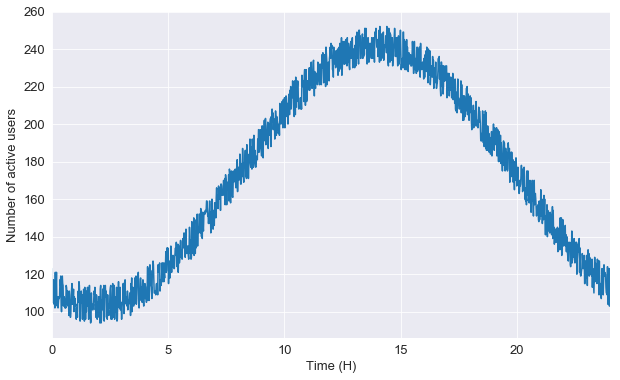

In [165]:
peak = 250
vtU=[]
for ii in range(0,60*24):
    vtU.append(lambdan(ii,peak))
seU=pd.Series(vtU)
seU.index=seU.index/(60)
seU.plot(figsize=(10,6))
plt.xlabel('Time (H)')
plt.ylabel('Number of active users')
plt.savefig('trafego-2.png')
plt.show()

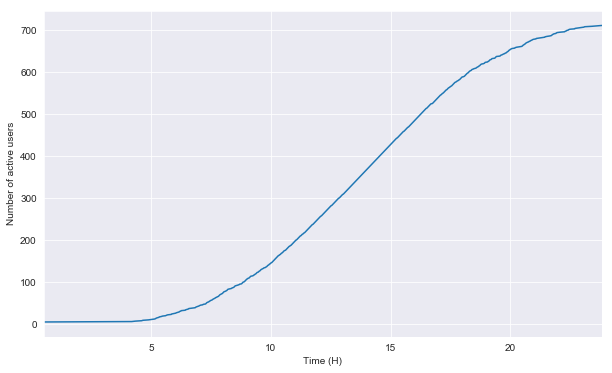

In [10]:
users = []
ii = []
user=5
for i in range(24*60):
    if np.random.uniform(low=0,high=2) <= 1+np.sin(2*np.pi*(960+i)/1440):
        users = np.append(users,user)
        ii.append(i)
        user = user+1
df = pd.Series(data = users,index=ii)
df.index = df.index/60
df.plot(figsize=(10,6))
plt.xlabel('Time (H)')
plt.ylabel('Number of active users')
plt.show()


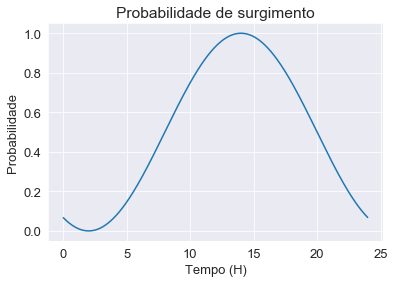

In [164]:
t = np.arange(24*60)
plt.plot(t/60,(1+np.sin(2*np.pi*(960+t)/1440))/2)
plt.xlabel('Tempo (H)')
plt.ylabel('Probabilidade')
plt.title('Probabilidade de surgimento')
#plt.savefig('Prob.png')
plt.show()

# Cenário 2

In [102]:
Pcnt=100 #fixed power
Pr=30 #Power per resource
maxre=25 #max number of resources
U=8 #max number of users by each resource
N=25 #quantization of users
peak=250 #peak of traffic
P=-1000 #penalization
epsilon=0.05 #epsilon for e-greedy
gamma=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] #discount rates
alpha=[0.3, 0.5, 0.7] #learning rates
maxEps=24*60*30 #Time for simulation: 30 days
dMC=20 #number of monte carlo simulations

# Q-Learning

In [97]:
vtBlock=np.zeros([len(alpha),len(gamma)])
vtEnS=np.zeros([len(alpha),len(gamma)])
states = def_state(peak,N,maxre)
for mc in range(dMC):
    for rate in range(0,len(alpha)):
        alphan=alpha[rate]
        for discount in range(0,len(gamma)):
            gamman=gamma[discount]
            QT = def_QT(states,maxre,N,U)
            re0 = np.random.randint(low=1,high=maxre+1)
            pblock=0
            EnS=0
            u0=lambdan(0,peak)
            for epoch in range(0,maxEps):
                state0 = pick_state(states,u0,re0,maxre,peak,N,U)
                a = epsilon_greedy(QT,states,state0,epsilon,maxre,U,N)
                r = reward(u0,re0,a,maxre,U,P)
                u0 = lambdan(epoch,peak)
                re1 = re0+(a+1-re0) 
                state1 = pick_state(states,u0,re1,maxre,peak,N,U)
                if r==P:
                    pblock=pblock+1
                QT[state0][a] = (1-alphan)*QT[state0][a] + alphan*(r + gamman*(QT[state1].max()))
                re0=re1
                EnS=EnS+(maxre-re0)
            vtBlock[rate][discount]=vtBlock[rate][discount]+pblock
            vtEnS[rate][discount]=vtEnS[rate][discount]+EnS

In [98]:
vtBlock=(vtBlock/maxEps)/dMC
vtEnS=((vtEnS/maxEps)*100/maxre)/dMC

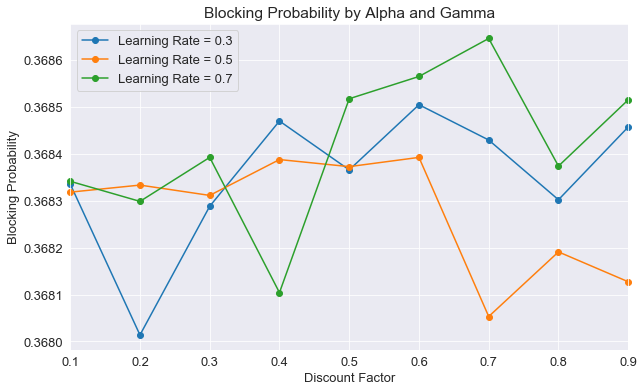

In [107]:
#dfBlock=pd.DataFrame(vtBlock.T,index=gamma,columns=alpha)
dfBlock.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Blocking Probability')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Blocking Probability by Alpha and Gamma')
plt.rc('font',size=13)
plt.savefig('block-2Q.png')
plt.show()

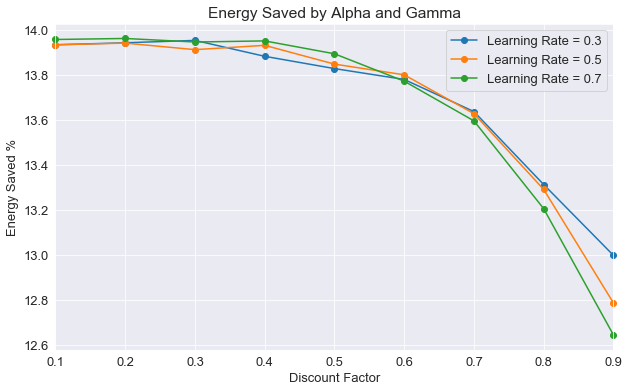

In [101]:
#dfEnS=pd.DataFrame((vtEnS).T,index=gamma,columns=alpha)
dfEnS.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Energy Saved %')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Energy Saved by Alpha and Gamma')
plt.rc('font',size=13)
plt.savefig('EnS-2Q.png')
plt.show()

# SARSA

In [132]:
vtBlock=np.zeros([len(alpha),len(gamma)])
vtEnS=np.zeros([len(alpha),len(gamma)])
states = def_state(peak,N,maxre)
for mc in range(dMC):
    for rate in range(0,len(alpha)):
        alphan=alpha[rate]
        for discount in range(0,len(gamma)):
            gamman=gamma[discount]
            QT = def_QT(states,maxre,N,U)
            re0 = np.random.randint(low=1,high=maxre+1)
            pblock=0
            EnS=0
            u0=lambdan(0,peak)
            for epoch in range(0,maxEps):
                state0 = pick_state(states,u0,re0,maxre,peak,N,U)
                a = epsilon_greedy(QT,states,state0,epsilon,maxre,U,N)
                r = reward(u0,re0,a,maxre,U,P)
                u0 = lambdan(epoch,peak)
                re1 = re0+(a+1-re0) 
                state1 = pick_state(states,u0,re1,maxre,peak,N,U)
                a1 = epsilon_greedy(QT,states,state1,epsilon,maxre,U,N)
                if r==P:
                    pblock=pblock+1
                QT[state0][a] = (1-alphan)*QT[state0][a] + alphan*(r + gamman*(QT[state1][a1]))
                re0=re1
                EnS=EnS+(maxre-re0)
            vtBlock[rate][discount]=vtBlock[rate][discount]+pblock
            vtEnS[rate][discount]=vtEnS[rate][discount]+EnS

In [133]:
vtBlock=(vtBlock/maxEps)/dMC
vtEnS=((vtEnS/maxEps)*100/maxre)/dMC

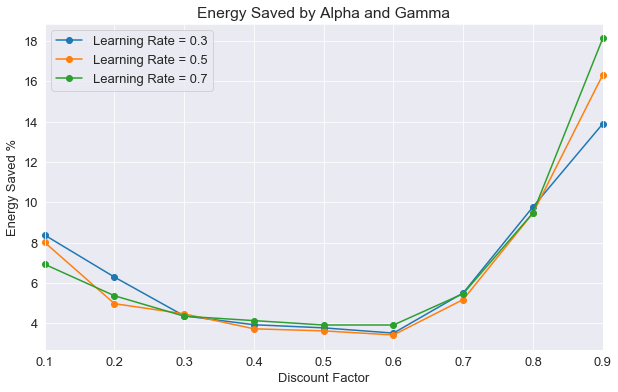

In [134]:
dfEnS=pd.DataFrame((vtEnS).T,index=gamma,columns=alpha)
dfEnS.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Energy Saved %')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Energy Saved by Alpha and Gamma')
plt.rc('font',size=13)
plt.savefig('EnS-2SARSA.png')
plt.show()

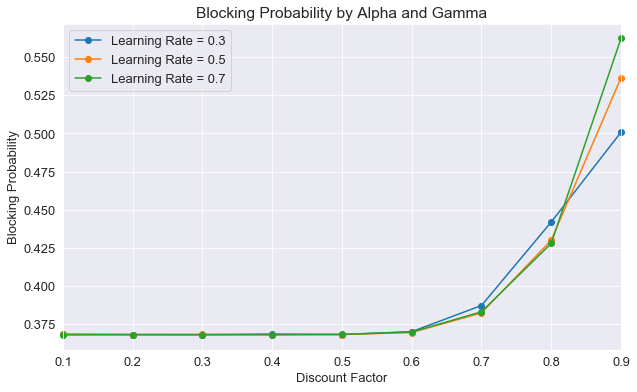

In [135]:
dfBlock=pd.DataFrame(vtBlock.T,index=gamma,columns=alpha)
dfBlock.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Blocking Probability')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Blocking Probability by Alpha and Gamma')
plt.rc('font',size=13)
plt.savefig('block-2SARSA.png')
plt.show()

# Expected SARSA

In [122]:
vtBlock=np.zeros([len(alpha),len(gamma)])
vtEnS=np.zeros([len(alpha),len(gamma)])
states = def_state(peak,N,maxre)
for mc in range(dMC):
    for rate in range(0,len(alpha)):
        alphan=alpha[rate]
        for discount in range(0,len(gamma)):
            gamman=gamma[discount]
            QT = def_QT(states,maxre,N,U)
            re0 = np.random.randint(low=1,high=maxre+1)
            pblock=0
            EnS=0
            u0=lambdan(0,peak)
            for epoch in range(0,maxEps):
                state0 = pick_state(states,u0,re0,maxre,peak,N,U)
                a = epsilon_greedy(QT,states,state0,epsilon,maxre,U,N)
                r = reward(u0,re0,a,maxre,U,P)
                u0 = lambdan(epoch,peak)
                re1 = re0+(a+1-re0) 
                state1 = pick_state(states,u0,re1,maxre,peak,N,U)
                if r==P:
                    pblock=pblock+1
                QT[state0][a] = (1-alphan)*QT[state0][a] + alphan*(r + gamman*np.mean(QT[state1][:]))
                re0=re1
                EnS=EnS+(maxre-re0)
            vtBlock[rate][discount]=vtBlock[rate][discount]+pblock
            vtEnS[rate][discount]=vtEnS[rate][discount]+EnS

In [123]:
vtBlock=(vtBlock/maxEps)/dMC
vtEnS=((vtEnS/maxEps)*100/maxre)/dMC

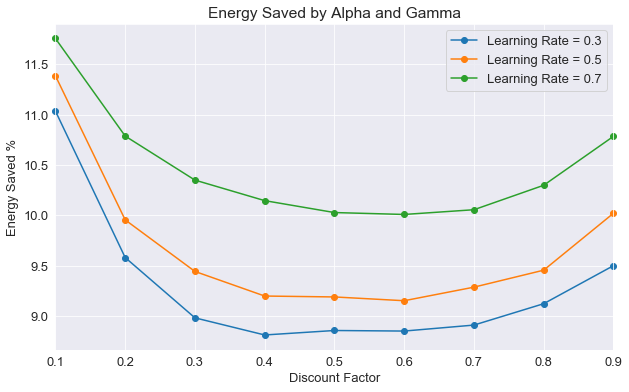

In [129]:
#dfEnS=pd.DataFrame((vtEnS).T,index=gamma,columns=alpha)
dfEnS.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Energy Saved %')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Energy Saved by Alpha and Gamma')
plt.rc('font',size=13)
plt.savefig('EnS-2ESARSA.png')
plt.show()

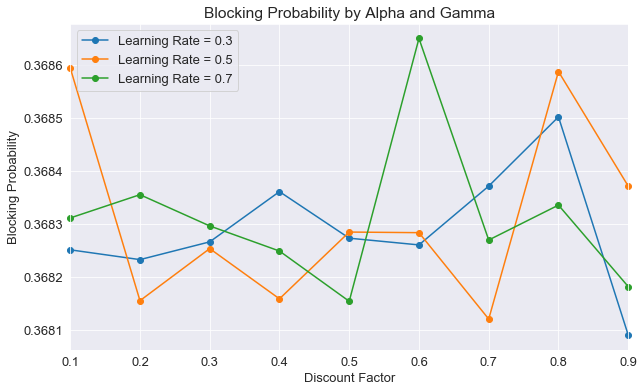

In [128]:
#dfBlock=pd.DataFrame(vtBlock.T,index=gamma,columns=alpha)
dfBlock.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Blocking Probability')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Blocking Probability by Alpha and Gamma')
plt.rc('font',size=13)
plt.savefig('block-2ESARSA.png')
plt.show()

# Cenário 3

In [141]:
maxre = 35 #Max quantidade de recursos
maxt = 35 #Taxa max oferecida
U = 1 #quantização
Pcnt = 100 #Potencia fixa
Pr = 30 #Potência por cada recurso
TpR = 1 #Taxa por recurso
epsilon = 0.05 # Prob de exploração
gamma=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] #discount rates
alpha=[0.3, 0.5, 0.7] #learning rates
maxEps=24*60*7 #Time for simulation: 30 days
dMC=10 #number of monte carlo simulations

# Q-Learning

In [144]:
vtEnS=np.zeros([len(alpha),len(gamma)])
vtTaxaN=np.zeros([len(alpha),len(gamma)])
vtTaxaP=np.zeros([len(alpha),len(gamma)])
states = def_state(maxt,U,maxre)
for mc in range(dMC):
    for rate in range(0,len(alpha)):
        alphan=alpha[rate]
        for discount in range(0,len(gamma)):
            gamman=gamma[discount]
            users = np.random.randint(low=1,high=25)
            re0 = np.random.randint(low=1,high=maxre+1)
            data_size,taxas = FTP(users)
            QT = np.zeros([(maxt+1)*(maxt*(maxre//U)),maxre])
            EnS = 0
            taxa_functionP= []
            taxa_functionN= []
            for i in range(maxEps):
                for troca in range(users):
                    if data_size[troca] < taxas[troca]:
                        taxas[troca],data_size[troca] = data_size[troca],taxas[troca]
                taxas_c = taxas
                fornecido = re0*TpR
                if sum(taxas)>fornecido:
                    taxa_functionN.append(np.absolute(sum(taxas)-fornecido))
                else:
                    taxa_functionP.append(np.absolute(sum(taxas)-fornecido))
                state0=pick_state(states,sum(taxas),re0,maxre,maxt,U,TpR)
                a = epsilon_greedy2(QT,state0,states,re0,epsilon,maxre,maxt)
                r = reward2(sum(taxas),re0,a,TpR)
                re1 = re0 + (1+a-re0)
                alocado = alocation(taxas_c,fornecido)
                data_size = data_size - alocado
                residuo = taxas - alocado
                for user in range(users):
                    if data_size[user] < taxas[user]:
                        taxas[user] = data_size[user]
                taxas_c = residuo + taxas
                nulos = np.where(data_size == 0)
                data_size = np.delete(data_size,(nulos))
                taxas = np.delete(taxas,(nulos))
                users = len(taxas)
                if np.random.uniform(low=0,high=2) <= 1+np.sin(2*np.pi*(960+i)/1440):
                    add_data,add_taxas = FTP(1)
                    data_size = np.append(data_size,add_data)
                    taxas = np.append(taxas,add_taxas)
                    users=users+1
                state1 = pick_state(states,sum(taxas),re1,maxre,maxt,U,TpR)
                QT[state0][a] = (1-alphan)*QT[state0][a] + alphan*(r + gamman*(QT[state1].max()))
                re0=re1
                EnS =EnS + maxre - re0
            vtEnS[rate][discount]=vtEnS[rate][discount]+EnS
            vtTaxaN[rate][discount] = vtTaxa[rate][discount] + np.mean(taxa_functionN)
            vtTaxaP[rate,discount] = vtTaxaP[rate,discount] + np.mean(taxa_functionP)
#plt.plot(np.linspace(0,24*30,len(taxa_function)),taxa_function)
#plt.show()

In [145]:
vtTaxaN = ((vtTaxaN/7))/dMC
vtTaxaP = ((vtTaxaP/7))/dMC
vtEnS=((vtEnS/maxEps)*100/maxre)/dMC

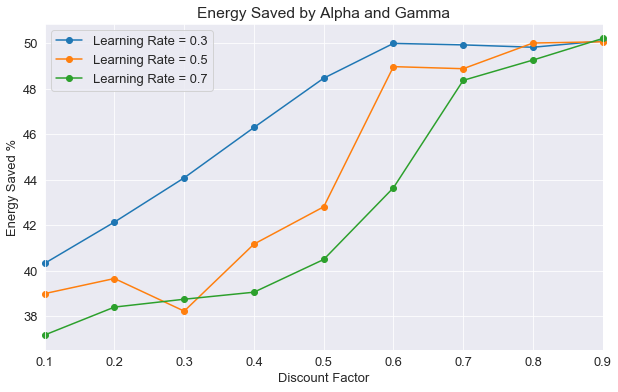

In [146]:
dfEnS=pd.DataFrame((vtEnS).T,index=gamma,columns=alpha)
dfEnS.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Energy Saved %')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Energy Saved by Alpha and Gamma')
plt.rc('font',size=13)
#plt.savefig('EnS-3Q.png',bbox_inches='tight')
plt.show()


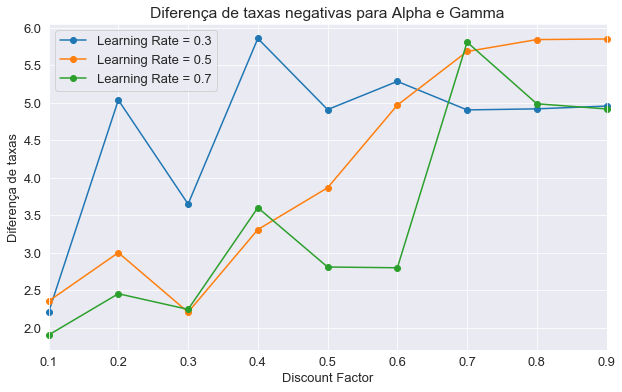

In [169]:
dfTaxa=pd.DataFrame(vtTaxaN.T,index=gamma,columns=alpha)
dfTaxa.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Diferença de taxas')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Diferença de taxas negativas para Alpha e Gamma')
plt.rc('font',size=13)
plt.savefig('taxaN.png')
plt.show()

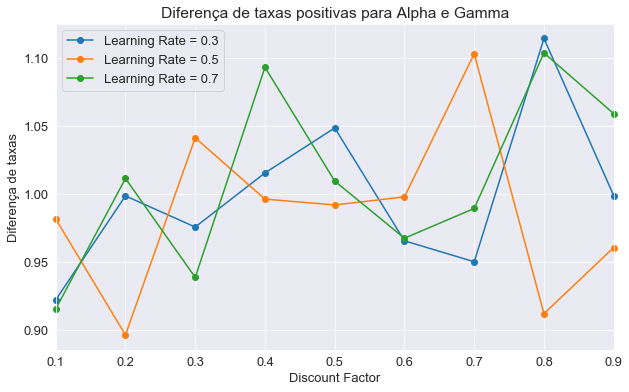

In [168]:
dfTaxa=pd.DataFrame(vtTaxaP.T,index=gamma,columns=alpha)
dfTaxa.plot(figsize=(10,6),marker='o',clip_on=False)
plt.ylabel('Diferença de taxas')
plt.xlabel('Discount Factor')
plt.legend(['Learning Rate = 0.3','Learning Rate = 0.5','Learning Rate = 0.7'])
plt.title('Diferença de taxas positivas para Alpha e Gamma')
plt.rc('font',size=13)
plt.savefig('taxaP.png')
plt.show()